In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
%matplotlib inline

# Lebwohl-Lasher Algorithm

First, we want to define our vectors in space:
\
\
We can do this in two ways - starting in the crystalline phase (i.e all in the same direction) or starting in the isotropic phase (i.e random directions). From there, we will "melt" or "freeze" our simulation depending on the starting conditions:
\
\
Additionally, our individual crystal vectors don't move in our model, so we can essentially do all of our "positions" in a single lattice array, and nearest neighbors are simply adjacent cells! This should lower computation time.

In [3]:
def initialize2(N:int, init_type:str, ran_seed:int):
    
    '''Uses Muller 1959 method of generating a random point on a (unit) sphere to create
    an NxNxN lattice of unit vectors 
    Returns three arrays of NxNxN which correspond to x,y,z coords'''
    
    if init_type == "random":
        
        rng = np.random.default_rng(seed=ran_seed)

        #want random unit vectors which correspond to uniform random points on a sphere
        
        lattice_x = rng.standard_normal(size=(N,N,N))
        lattice_y = rng.standard_normal(size=(N,N,N))
        lattice_z = rng.standard_normal(size=(N,N,N))
        
        #normalize
        for i in range(N):
            for j in range(N):
                for k in range(N):
                    vec = np.array([lattice_x[i,j,k],lattice_y[i,j,k],lattice_z[i,j,k]])
                    norm = np.linalg.norm(vec)
                    lattice_x[i,j,k] /= norm
                    lattice_y[i,j,k] /= norm
                    lattice_z[i,j,k] /= norm
        
    if init_type == "uniform":
        
        "We are defining the z direction as where they will all point at start"
        
        lattice_x = np.zeros((N,N,N))
        
        lattice_y = np.zeros((N,N,N))
        
        lattice_z = np.ones((N,N,N))
        
    return lattice_x, lattice_y, lattice_z 

The two following functions compute our energy for one LL bond, and then our energy for one lattice site over all of its nearest neighbors:

In [4]:
def ene(dotproduct):
    '''Simple energy calculation for one interaction, this will be summed and scaled for any
    monte carlo steps'''
    
    #set some value for epsilon, always gonna be one I think
    epsilon = 1
    
    #theta is the angle btw the long axis of two crystals
    return -(1.5*((dotproduct)**2)-1/2)

In [5]:
def ene_tot2(lattice_x,lattice_y,lattice_z, pos):
    '''Take a particle lattice position (i.e like (1,4,3) or something), and return its energy
    Note: lattices actually have no position in real space, they are simply anchored to a lattice site. They,
    however, have x,y,z coordinates in the sense of a displacement from their lattice site(this is the conversion
    from spherical coordinates)'''
    
    N = lattice_x.shape[0]
    
    x_c = lattice_x[pos]
    y_c = lattice_y[pos]
    z_c = lattice_z[pos]
    
    
    #make vector
    vec_c = np.array([x_c,y_c,z_c])
    
    
    i = pos[0]
    j = pos[1]
    k = pos[2]
    
    #first, check for PBC
    #'downward' conditions will occur automatically, as i-1 will wrap around to -1 automatically for a 0 pos
    #'upward' conditions must be manually checked
    
    if i == N - 1:
        imax = 0
    
    else:
        imax = i + 1
        
    if j == N - 1:
        jmax = 0
    
    else:
        jmax = j + 1
    
    if k == N - 1:
        kmax = 0
    else:
        kmax = k + 1
        
    
    total_energy = 0

    for (l,m,n) in [(i,jmax,k),(i,j-1,k),(imax,j,k),(i-1,j,k),(i,j,kmax),(i,j,k-1)]:
               
            x_n = lattice_x[l,m,n]
            y_n = lattice_y[l,m,n]
            z_n = lattice_z[l,m,n]

            vec_n = np.array([x_n,y_n,z_n])

            dot_a = np.dot(vec_c,vec_n)
            
            total_energy += ene(dot_a)
                
                
    return total_energy

This function chooses a random lattice site. It is defunct in my current method of just passing through the lattice in order a certain number of times, but works properly if used in an algorithm that runs metropolis steps on random points in the lattice

In [6]:
def choose(N):
    '''Chooses a particle at random from an NxNxN lattice'''
    
    i,j,k = np.random.randint(N, size = 3)
    
    return i,j,k

This code rotates a lattice site vector to another random orientation within the unit sphere:

In [7]:
def shift2(lattice_x,lattice_y,lattice_z,pos, rng):
    '''Takes lattice positions and randomly reorients them in the unit sphere'''
    
    
    x_shift = np.random.standard_normal()
    y_shift = np.random.standard_normal()
    z_shift = np.random.standard_normal()
    
    vec = np.array([x_shift,y_shift,z_shift])
    norm = np.linalg.norm(vec)
    
    x_shift /= norm
    y_shift /= norm
    z_shift /= norm
    
    lattice_x[pos] = x_shift
    lattice_y[pos] = y_shift
    lattice_z[pos] = z_shift
    

This code, like shift() is now defunct. It works properly, but I found the lattice pass method to be preferable.

In [8]:
def metrop2(lattice_x, lattice_y, lattice_z, rng, beta):
    '''For use at point not near the expected phase change. Points near phase change will experience
    "critical slowing down", and thus the single-cluster algorithm should be applied'''
    '''Takes lattice arrays, of which it is assumed lattice[0] is theta angles and lattice[1] are azimuthal angles'''
    
    #Choose a random particle
    coords = choose(lattice_x.shape[0])
        
    #store initial energy of this particle
    ene_init = ene_tot2(lattice_x,lattice_y,lattice_z,coords)
    
    #store initial positions:
    init_x = lattice_x[coords].copy()
    init_y = lattice_y[coords].copy()
    init_z = lattice_z[coords].copy()
    
    #shift particle randomly
    shift2(lattice_x,lattice_y,lattice_z,coords,rng)
        
    #calculate new energy
    ene_new = ene_tot2(lattice_x,lattice_y,lattice_z,coords)
        
    #check metropolis conditions:
    delta_ene = ene_new - ene_init
    r = rng.random()
    
    if ene_new <= ene_init:
        #accept
        pass
        
        
    if r <= np.exp(-beta * delta_ene):
        #accept
        pass

    else:
        #reject
        lattice_x[coords] = init_x
        lattice_y[coords] = init_y
        lattice_z[coords] = init_z

This is the code that runs our metropolis algorithm. For one call it passes through the whole lattice, updating each site according to the metropolis algorithm.

In [9]:
def lattice_pass(lattice_x, lattice_y, lattice_z, rng, beta):
    N = lattice_x.shape[0]
    
    for i in range(N):
        for j in range(N):
            for k in range(N):
                coords = (i,j,k)  
                        
                #store initial energy of this particle
                ene_init = ene_tot2(lattice_x,lattice_y,lattice_z,coords)
                
                #store initial positions:
                init_x = lattice_x[coords].copy()
                init_y = lattice_y[coords].copy()
                init_z = lattice_z[coords].copy()
                
                #shift particle randomly
                shift2(lattice_x,lattice_y,lattice_z,coords,rng)

                #calculate new energy
                ene_new = ene_tot2(lattice_x,lattice_y,lattice_z,coords)

                #check metropolis conditions:
                delta_ene = ene_new - ene_init
                r = rng.random()

                if ene_new <= ene_init:
                    #accept
                    pass


                if r <= np.exp(-beta * delta_ene):
                    #accept
                    pass

                else:
                    #reject
                    lattice_x[coords] = init_x
                    lattice_y[coords] = init_y
                    lattice_z[coords] = init_z


Below is a sampel cell of how to generate outputs for the energy observable and some outputs for various temperatures. It is important to note that the raw energy outputs double count, so they should be divided by 2 after a run. Additionally, I looked at energy per site, so I then divided by 1000. So for all of the graphical outputs, I ran energy_list# = np.array(energy_list#)/2000.

In [1177]:
seed_choice = 17222
lattice_testx, lattice_testy, lattice_testz = initialize2(10,"random",2722)
rng = np.random.default_rng(seed=17)
ene_list7 = []
time1 = time.time()
for t in range(1000):
    
    lattice_pass(lattice_testx,lattice_testy,lattice_testz,rng,0)
    
    if t%100 == 0:
        print(t/1000 * 100)
    
    #record system energy:
    ene_sum = 0
    for q in range(10):
        for y in range(10):
            for z in range(10):
                ene_sum += ene_tot2(lattice_testx,lattice_testy,lattice_testz,(q,y,z))
    ene_list7.append(ene_sum)
print(time.time()-time1)

0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
63.71495819091797


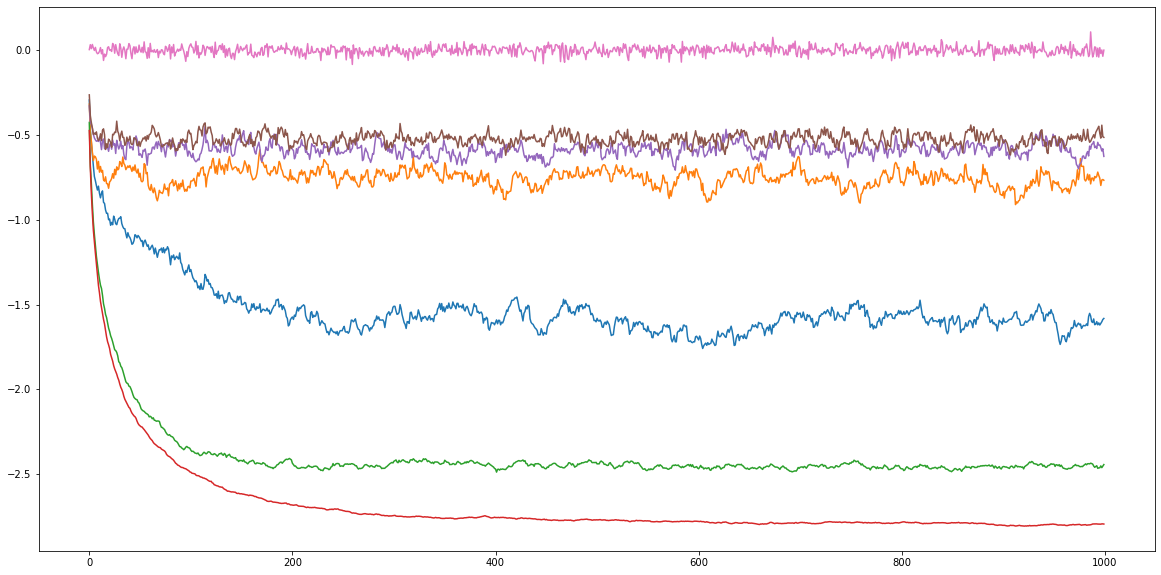

In [1186]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(ene_list1)
ax.plot(ene_list2)
ax.plot(ene_list3)
ax.plot(ene_list4)
ax.plot(ene_list5)
ax.plot(ene_list6)
ax.plot(ene_list7)

Below is an early test graph to see if I could observe a discontinuity in the system energy. You can see it was successful.

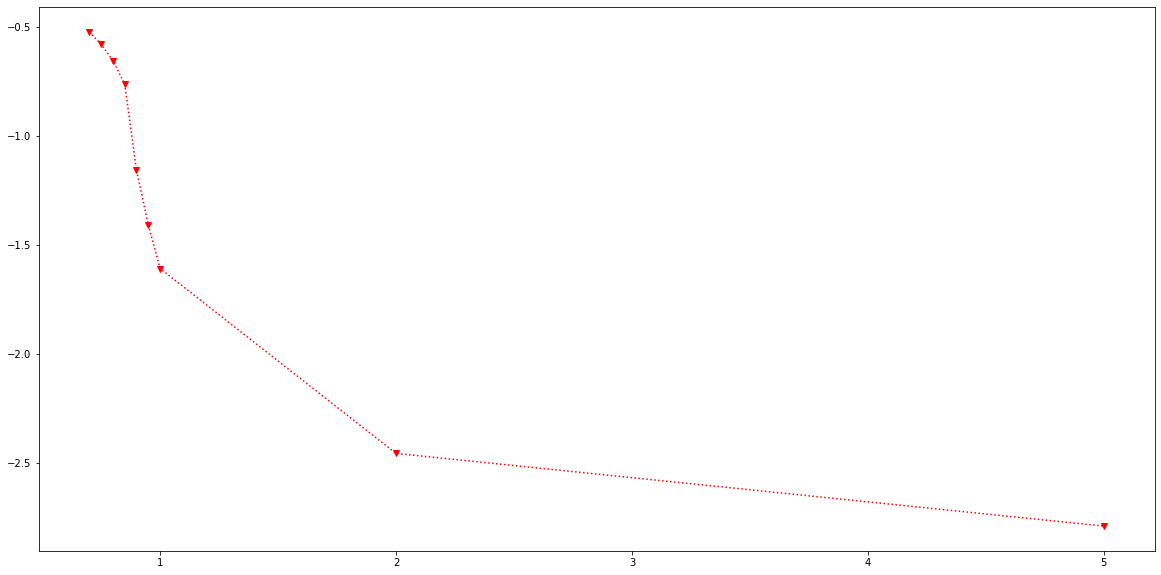

In [1161]:
fig, ax = plt.subplots(figsize=(20,10))
beta_list = [0.7,0.75,0.8,0.85,0.9,0.95,1,2,5]
ene_lists = [-0.5247448712808478,-0.5810702372263638,-0.6559542415176607,-0.7630351762679358,-1.158643781339922,-1.4082775435829253, -1.6085656723625539,-2.4554506916633407,-2.7882610510707746]
plt.plot(beta_list,ene_lists,'r', linestyle='dotted', marker='v')

It could be useful to now graph the average energy for several beta values (i.e a continuous list)

In [1168]:
beta_list1 = np.linspace(0,2,100)

In [1166]:
beta_list2 = np.linspace(2,10,50)

In [1172]:
beta_list = np.concatenate((beta_list1,beta_list2))

In [1189]:
beta_list

array([ 0.        ,  0.02020202,  0.04040404,  0.06060606,  0.08080808,
        0.1010101 ,  0.12121212,  0.14141414,  0.16161616,  0.18181818,
        0.2020202 ,  0.22222222,  0.24242424,  0.26262626,  0.28282828,
        0.3030303 ,  0.32323232,  0.34343434,  0.36363636,  0.38383838,
        0.4040404 ,  0.42424242,  0.44444444,  0.46464646,  0.48484848,
        0.50505051,  0.52525253,  0.54545455,  0.56565657,  0.58585859,
        0.60606061,  0.62626263,  0.64646465,  0.66666667,  0.68686869,
        0.70707071,  0.72727273,  0.74747475,  0.76767677,  0.78787879,
        0.80808081,  0.82828283,  0.84848485,  0.86868687,  0.88888889,
        0.90909091,  0.92929293,  0.94949495,  0.96969697,  0.98989899,
        1.01010101,  1.03030303,  1.05050505,  1.07070707,  1.09090909,
        1.11111111,  1.13131313,  1.15151515,  1.17171717,  1.19191919,
        1.21212121,  1.23232323,  1.25252525,  1.27272727,  1.29292929,
        1.31313131,  1.33333333,  1.35353535,  1.37373737,  1.39

In [1234]:
beta_list2 = np.linspace(6,10,10)

We run over our beta values and produce a list of the average energies for each one. The average values are scaled according to the method described above.

In [1235]:
seed_choice = 17222
rng = np.random.default_rng(seed=17)

final_energy_list2 = []
count = 0 
for beta_s in beta_list2:
    print(count)
    lattice_testx, lattice_testy, lattice_testz = initialize2(10,"uniform",2722)
    ene_list = []
    #run 2000 passes, 1000 to equilibrate, 1000 to average
    for t in range(2000):
        lattice_pass(lattice_testx,lattice_testy,lattice_testz,rng,beta_s)

        #record system energy:
        if t >= 1000:
            ene_sum = 0
            for q in range(10):
                for y in range(10):
                    for z in range(10):
                        ene_sum += ene_tot2(lattice_testx,lattice_testy,lattice_testz,(q,y,z))
            ene_list.append(ene_sum)
    ene_list = np.array(ene_list)/2000
    final_energy_list2.append(np.mean(ene_list))
    count +=1

0
1
2
3
4
5
6
7
8
9


We can see that this produces the desired outputs for our LL lattice

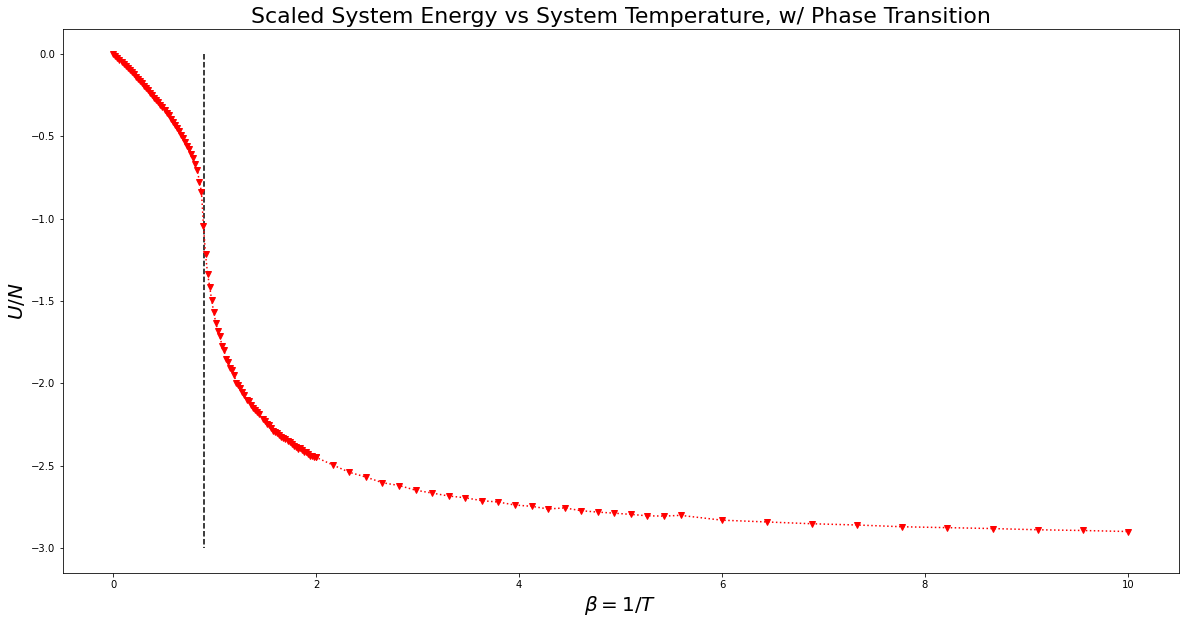

In [1373]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(beta_list_final, final_energy_list3, 'r', linestyle='dotted', marker='v')
ax.vlines(0.89,0,-3, 'k', linestyle ='dashed')
ax.set_xlabel(r'$\beta  = 1/T$', fontsize = 20)
ax.set_ylabel(r'$U/N$', fontsize = 20)
ax.set_title("Scaled System Energy vs System Temperature, w/ Phase Transition", fontsize = 22)
plt.show()

Text(0.5, 1.0, 'Scaled System Energy vs System Temperature, w/ Phase Transition')

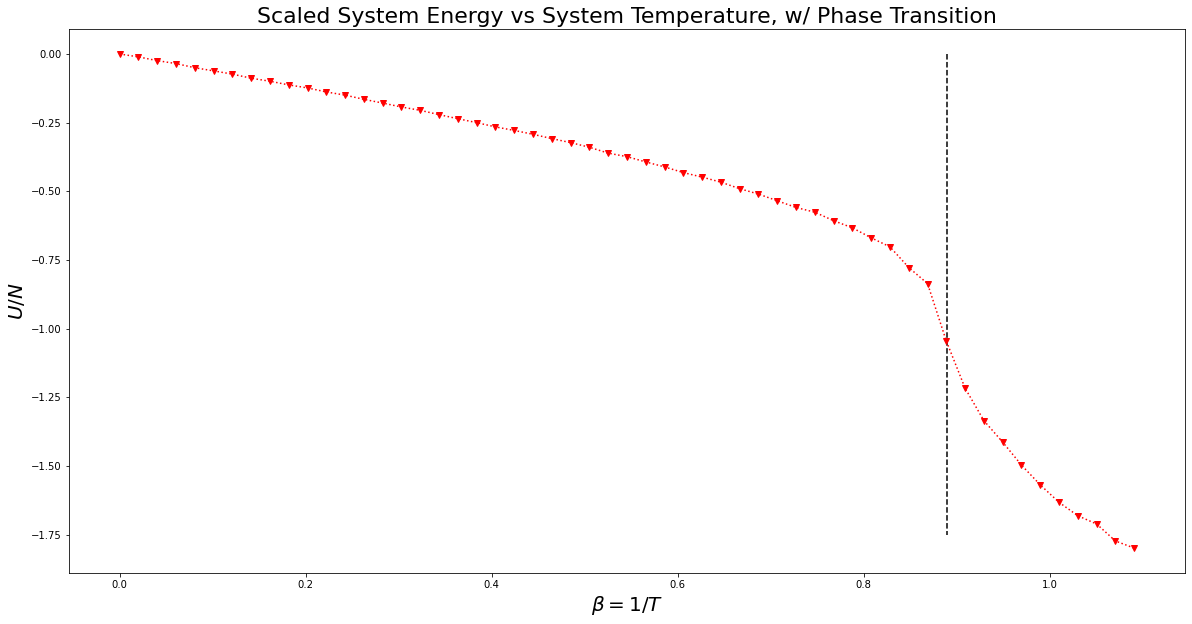

In [1274]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(beta_list_final[0:55], final_energy_list3[0:55], 'r', linestyle='dotted', marker='v')
ax.vlines(0.89,0,-1.75, 'k', linestyle ='dashed')
ax.set_xlabel(r'$\beta  = 1/T$', fontsize = 20)
ax.set_ylabel(r'$U/N$', fontsize = 20)
ax.set_title("Scaled System Energy vs System Temperature, w/ Phase Transition", fontsize = 22)

We now do this again for a 20x20x20 lattice. This process should work for all lattice sizes, but the time necessary to run a larger lattice increases quite dramatically, so I did not run for any sizes larger than this

In [1277]:
beta_list3 = np.linspace(0,2,100)

In [1279]:
beta_list4 = np.linspace(2,10,25)

array([ 2.        ,  2.33333333,  2.66666667,  3.        ,  3.33333333,
        3.66666667,  4.        ,  4.33333333,  4.66666667,  5.        ,
        5.33333333,  5.66666667,  6.        ,  6.33333333,  6.66666667,
        7.        ,  7.33333333,  7.66666667,  8.        ,  8.33333333,
        8.66666667,  9.        ,  9.33333333,  9.66666667, 10.        ])

In [1281]:
seed_choice = 17222
rng = np.random.default_rng(seed=17)

final_energy_list4 = []
count = 0 
for beta_s in beta_list3:
    print(count)
    lattice_testx, lattice_testy, lattice_testz = initialize2(20,"random",2722)
    ene_list = []
    #run 2000 passes, 1000 to equilibrate, 1000 to average
    for t in range(2000):
        lattice_pass(lattice_testx,lattice_testy,lattice_testz,rng,beta_s)

        #record system energy:
        if t >= 1000:
            ene_sum = 0
            for q in range(10):
                for y in range(10):
                    for z in range(10):
                        ene_sum += ene_tot2(lattice_testx,lattice_testy,lattice_testz,(q,y,z))
            ene_list.append(ene_sum)
    ene_list = np.array(ene_list)/2000
    final_energy_list4.append(np.mean(ene_list))
    count +=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [1282]:
seed_choice = 17222
rng = np.random.default_rng(seed=17)

final_energy_list5 = []
count = 0 
for beta_s in beta_list4:
    print(count)
    lattice_testx, lattice_testy, lattice_testz = initialize2(20,"uniform",2722)
    ene_list = []
    #run 2000 passes, 1000 to equilibrate, 1000 to average
    for t in range(2000):
        lattice_pass(lattice_testx,lattice_testy,lattice_testz,rng,beta_s)

        #record system energy:
        if t >= 1000:
            ene_sum = 0
            for q in range(10):
                for y in range(10):
                    for z in range(10):
                        ene_sum += ene_tot2(lattice_testx,lattice_testy,lattice_testz,(q,y,z))
            ene_list.append(ene_sum)
    ene_list = np.array(ene_list)/2000
    final_energy_list5.append(np.mean(ene_list))
    count +=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [1284]:
final_energy_list_big = np.concatenate((final_energy_list4, final_energy_list5))

In [1286]:
final_beta_list_big = np.concatenate((beta_list3, beta_list4))

Again, good results, but some could have used more time to equilibrate as can be seen.

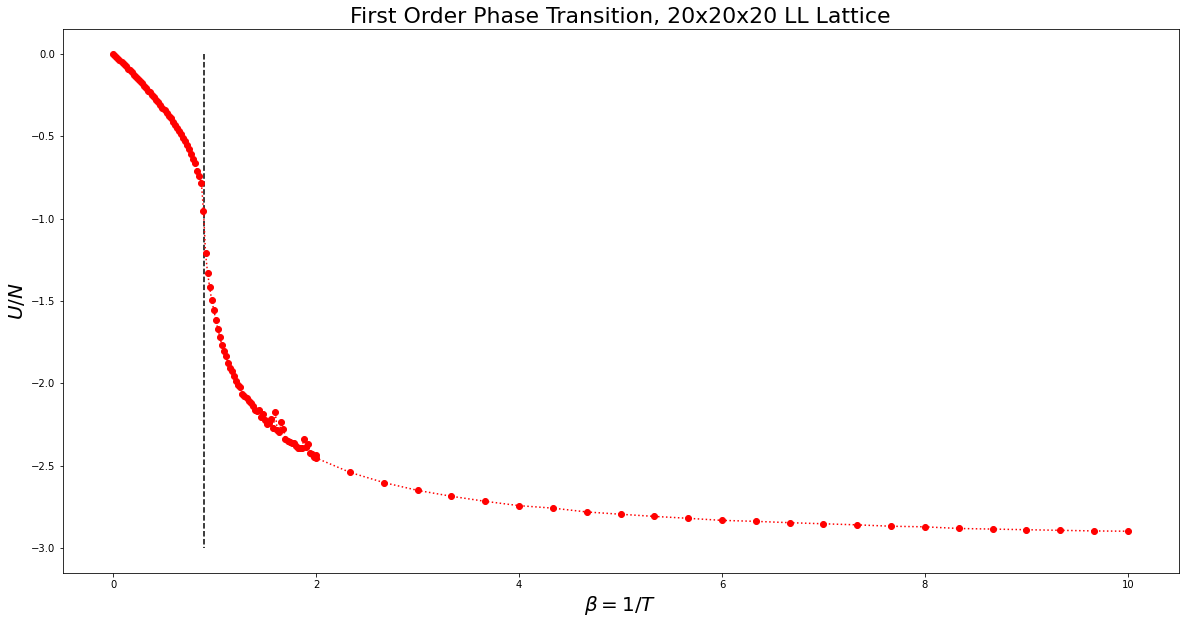

In [1376]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(final_beta_list_big, final_energy_list_big, 'r', linestyle = 'dotted', marker = 'o')
ax.vlines(0.89,0,-3, 'k', linestyle ='dashed')
ax.set_ylabel(r'$U/N$', fontsize = 20)
ax.set_xlabel(r'$\beta  = 1/T$', fontsize = 20)
ax.set_title("First Order Phase Transition, 20x20x20 LL Lattice", fontsize = 22)
plt.show()

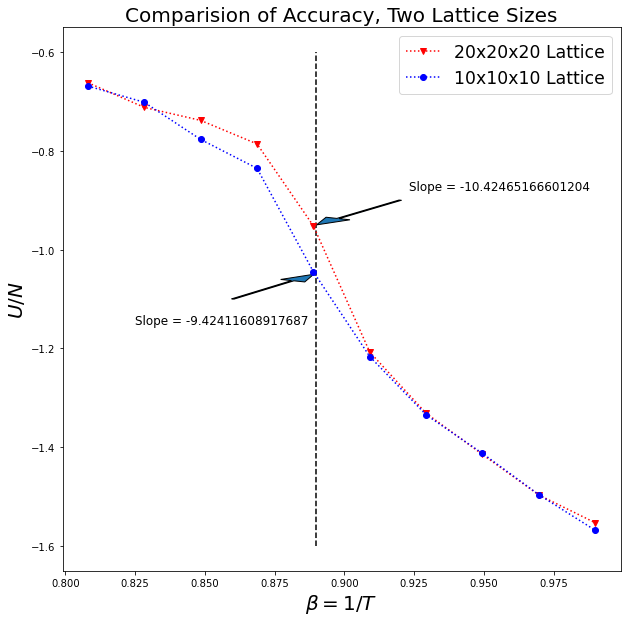

In [1377]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(final_beta_list_big[40:50], final_energy_list_big[40:50], 'r', linestyle = 'dotted', marker='v', label = "20x20x20 Lattice")
ax.plot(beta_list_final[40:50], final_energy_list3[40:50], 'b', linestyle='dotted', marker='o', label = "10x10x10 Lattice")
ax.vlines(0.89, -1.6,-0.6, 'k', linestyle = 'dashed')
ax.legend(fontsize = 'xx-large')
ax.arrow(0.92,-0.9, -0.03, -0.05, length_includes_head = True, head_width = 0.01)
ax.arrow(0.860, -1.1,0.029,0.05, length_includes_head = True, head_width =0.01)
ax.text(0.825, -1.15, "Slope = -9.42411608917687", fontsize = 'large')
ax.text(0.923, -0.88, "Slope = -10.42465166601204", fontsize = 'large')
ax.set_ylabel(r'$U/N$', fontsize = 20)
ax.set_xlabel(r'$\beta  = 1/T$', fontsize = 20)
ax.set_title("Comparision of Accuracy, Two Lattice Sizes", fontsize = 20)
plt.show()

In [1317]:
(final_energy_list_big[45] - final_energy_list_big[43])/(final_beta_list_big[45]-final_beta_list_big[43])

-10.42465166601204

In [1318]:
(final_energy_list3[45] - final_energy_list3[43])/(beta_list_final[45] - beta_list_final[43])

-9.42411608917687

We now define a function to compute the order parameter according to the tensor method outlined in the report and slides. Numpy linear algebra functions are very helpful here.

In [127]:
def order(lattice_x, lattice_y, lattice_z):
    
    N_l = lattice_x.shape[0]
    Q = 0
    
    for i in range(N_l):
        for j in range(N_l):
            for k in range(N_l):
                
                vec = np.array([[lattice_x[i,j,k],lattice_y[i,j,k],lattice_z[i,j,k]]])
                
                #use tensor equation
                                
                Q += ((vec*(vec.T)) - ((1/3)*np.eye(3)))
    
    #average
    
    Q /= (N_l**3)
    
    
    #diagonalize
    
    eigenvalues = np.linalg.eigh(Q)[0] #should be an array of REAL eigenvalues
    
    P2 = (3/2)*max(eigenvalues)
    
    return P2

And a heat capacity function, simply using the variance of the energy.

In [168]:
def CV(ene_list, beta):
    '''computes heat capacity for a given temperature'''
    
    
    variance = np.var(ene_list)
    
    T = 1/beta
    
    heat_cap = variance/(T**2)
    
    return heat_cap
    
    

Below are some tests to make sure that the order function works. We can see we do return a value of nearly 1 for a uniform lattice, and, although not currently written, would return a value close to zero for a random lattice.

In [146]:
lattice_x, lattice_y, lattice_z = initialize2(10, "uniform", 11)

In [147]:
order(lattice_x,lattice_y,lattice_z)

0.9999999999999954

Now, we run some functions to produce outputs for these two observables. It is important to note that for the run length we used for energy, a good bit of the systems did not equilibrate, so it might be best to run for longer than 2000 lattice passes to pull these variables.

In [131]:
beta_list_order = np.concatenate((np.linspace(0,1.2,25),np.linspace(1.3,10,25)))

In [166]:
beta_list_order

array([1.0000e-03, 5.0000e-02, 1.0000e-01, 1.5000e-01, 2.0000e-01,
       2.5000e-01, 3.0000e-01, 3.5000e-01, 4.0000e-01, 4.5000e-01,
       5.0000e-01, 5.5000e-01, 6.0000e-01, 6.5000e-01, 7.0000e-01,
       7.5000e-01, 8.0000e-01, 8.5000e-01, 9.0000e-01, 9.5000e-01,
       1.0000e+00, 1.0500e+00, 1.1000e+00, 1.1500e+00, 1.2000e+00,
       1.3000e+00, 1.6625e+00, 2.0250e+00, 2.3875e+00, 2.7500e+00,
       3.1125e+00, 3.4750e+00, 3.8375e+00, 4.2000e+00, 4.5625e+00,
       4.9250e+00, 5.2875e+00, 5.6500e+00, 6.0125e+00, 6.3750e+00,
       6.7375e+00, 7.1000e+00, 7.4625e+00, 7.8250e+00, 8.1875e+00,
       8.5500e+00, 8.9125e+00, 9.2750e+00, 9.6375e+00, 1.0000e+01])

In [169]:
seed_choice = 17222
rng = np.random.default_rng(seed=17)
final_order_list = []
count = 0 
order_list = []
heat_cap_list = []
time1 = time.time()
for beta_s in beta_list_order:
    order_list = []
    energy_list = []
    print(count)
    print(time.time()-time1)
    lattice_testx, lattice_testy, lattice_testz = initialize2(10,"random",2722)
    #run 2000 passes, 1000 to equilibrate, 1000 to average
    for t in range(2000):
        lattice_pass(lattice_testx,lattice_testy,lattice_testz,rng,beta_s)
        #record system order:
        if t >= 1000:
            ene_sum = 0
            for q in range(10):
                for y in range(10):
                    for z in range(10):
                        ene_sum += ene_tot2(lattice_testx,lattice_testy,lattice_testz,(q,y,z))
            energy_list.append(ene_sum)
            order_t = order(lattice_testx, lattice_testy,lattice_testz)
            order_list.append(order_t)
            
    heat_capacity = CV(energy_list, beta_s)
    heat_cap_list.append(heat_capacity)
    final_order_list.append(np.mean(order_list))
    count +=1

0
0.0007679462432861328
1
110.37559127807617
2
221.20410227775574
3
331.7659499645233
4
442.7715470790863
5
554.2072188854218
6
665.9736819267273
7
781.596773147583
8
896.1145050525665
9
1010.9198501110077
10
1126.207247018814
11
1242.8743720054626
12
1355.971803188324
13
1472.1561069488525
14
1584.4227001667023
15
1696.271739244461
16
1808.8463008403778
17
1921.7928540706635
18
2034.4355840682983
19
2147.6822440624237
20
2260.8838579654694
21
2373.241891145706
22
2485.7035052776337
23
2600.749366044998
24
2713.879097223282
25
2826.8958899974823
26
2938.1623899936676
27
3051.9993662834167
28
3165.4925520420074
29
3277.6803851127625
30
3391.8388888835907
31
3506.8665940761566
32
3622.1703491210938
33
3735.171792268753
34
3851.351061105728
35
3965.8930361270905
36
4078.525447845459
37
4192.427711009979
38
4306.637713193893
39
4419.342573165894
40
4531.911076068878
41
4644.877109050751
42
4757.860730171204
43
4870.811563014984
44
4982.73957824707
45
5094.743373155594
46
5207.13960814476
4

In [160]:
order_list[-1000]

0.9213400985306137

Text(0.5, 1.0, 'Order Parameter for First Order Phase Transition, 10x10x10 Lattice')

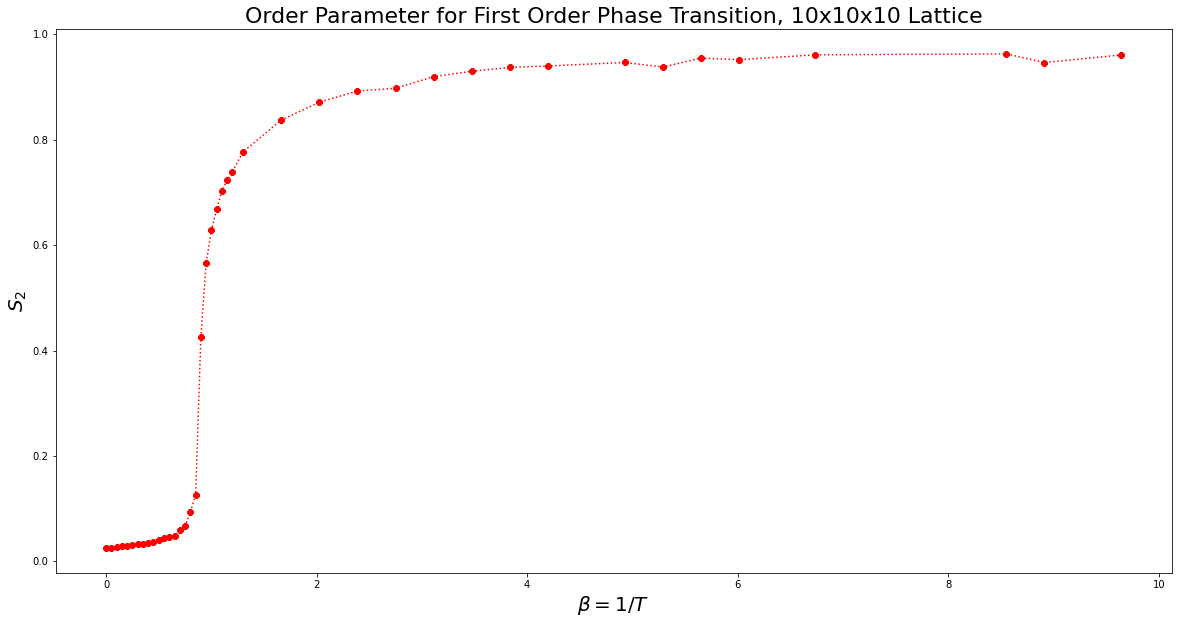

In [202]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(beta_list_order2, final_order_list2, 'r', linestyle='dotted', marker = '8')
ax.set_ylabel(r'$S_2$', fontsize = 20)
ax.set_xlabel(r'$\beta  = 1/T$', fontsize = 20)
ax.set_title("Order Parameter for First Order Phase Transition, 10x10x10 Lattice", fontsize = 22)

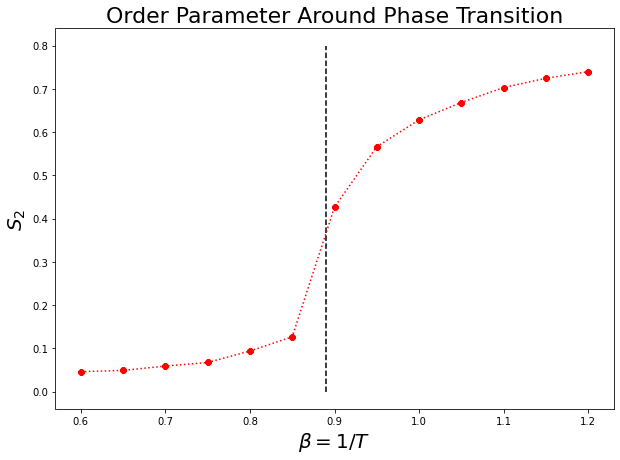

In [203]:
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(beta_list_order2[12:25], final_order_list2[12:25], 'r', linestyle='dotted', marker = '8')
ax.set_ylabel(r'$S_2$', fontsize = 20)
ax.set_xlabel(r'$\beta  = 1/T$', fontsize = 20)
ax.set_title("Order Parameter Around Phase Transition", fontsize = 22)
ax.vlines(0.89, 0,0.8, 'k', linestyle = 'dashed')

In [182]:
final_order_list2 = np.delete(final_order_list, [34,39,41,42,43,44,47,49])

In [185]:
beta_list_order2 = np.delete(beta_list_order, [34,39,41,42,43,44,47,49])

In [183]:
final_order_list2

array([0.02514161, 0.02571527, 0.02730209, 0.02827503, 0.02927664,
       0.03125297, 0.03199072, 0.03363938, 0.03460349, 0.037467  ,
       0.03972497, 0.04357913, 0.04593648, 0.04880962, 0.05881702,
       0.06709054, 0.0936763 , 0.12658237, 0.42627788, 0.56607306,
       0.62824227, 0.66833935, 0.70293762, 0.72433756, 0.73967259,
       0.77694173, 0.83733109, 0.87132663, 0.8925312 , 0.89772132,
       0.91981018, 0.93007828, 0.93732939, 0.9400301 , 0.94679752,
       0.93798595, 0.95500782, 0.9520132 , 0.96126688, 0.9629674 ,
       0.94655784, 0.96089851])

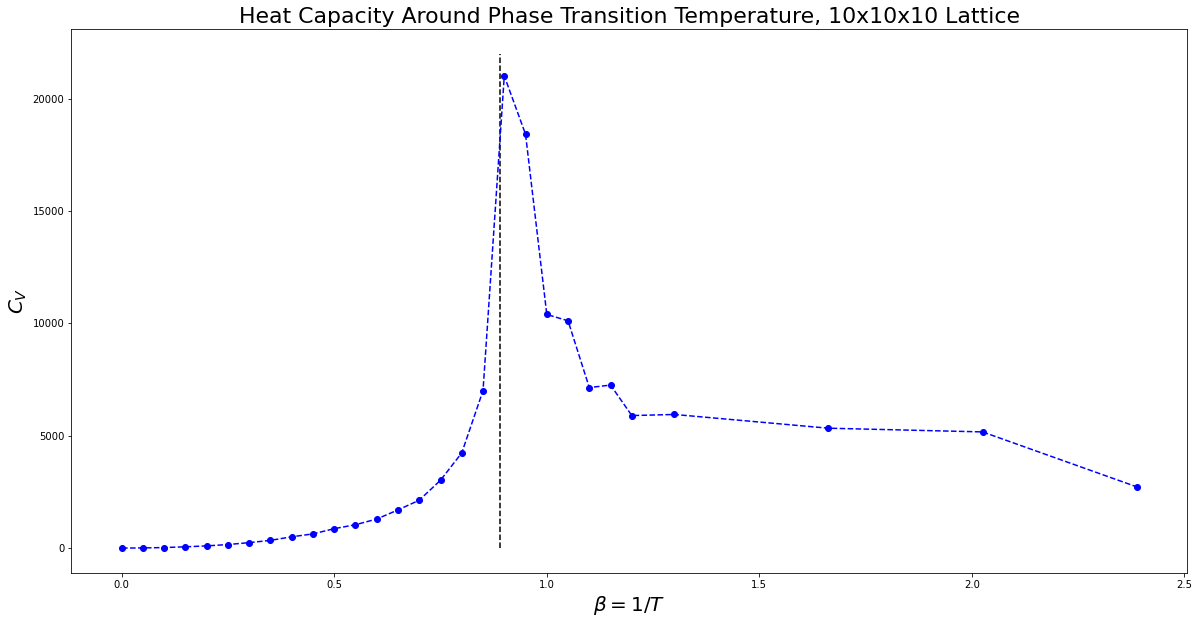

In [204]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(beta_list_order[0:29], heat_cap_list[0:29], 'blue', linestyle = 'dashed', marker ='o')
ax.set_ylabel(r'$C_V$', fontsize = 20)
ax.set_xlabel(r'$\beta  = 1/T$', fontsize = 20)
ax.set_title("Heat Capacity Around Phase Transition Temperature, 10x10x10 Lattice", fontsize = 22)
ax.vlines(0.89, 0,22000, 'k', linestyle = 'dashed')

# Wolff Cluster Algorithm

Now, we want to try to implement the cluster algorithm for our model to replace the Metropolis steps used prior. First, let's make sure we can properly generate the rotation operator

In [12]:
rng = np.random.default_rng(seed=17)

In [22]:
r_hat = np.array([rng.standard_normal(),rng.standard_normal(),rng.standard_normal()])

In [24]:
r_hat = r_hat/np.linalg.norm(r_hat)

In [26]:
np.sum(r_hat**2)

1.0

In [50]:
def rotation(lattice_x, lattice_y, lattice_z, ind, r_hat):
    '''
    Takes a lattice site and direction r_hat and rotates it according to the rotation operator in Priesjev and Pelcovitz
    '''
    
    x_r = lattice_x[ind]
    y_r = lattice_y[ind]
    z_r = lattice_z[ind]
    
    lattice_vec_r = np.array([x_r,y_r,z_r])
    
    #rotate
    lattice_vec_new = -lattice_vec_r + (2*np.dot(lattice_vec_r, r_hat))*r_hat
    
    #reassign
    lattice_x[ind] = lattice_vec_new[0]
    lattice_y[ind] = lattice_vec_new[1]
    lattice_z[ind] = lattice_vec_new[2]

Then, we define a function to compute the probability of cluster acceptance.

In [44]:
def cluster_prob(lattice_x,lattice_y,lattice_z, ind_i, ind_j, r_hat, T):
    '''
    Computs the cluster probability from Priejev & Pelcovitz, index i should be flipped according to the reflection
    operator prior to this being called
    '''
    
    x_i = lattice_x[ind_i]
    y_i = lattice_y[ind_i]
    z_i = lattice_z[ind_i]
    
    x_j = lattice_x[ind_j]
    y_j = lattice_y[ind_j]
    z_j = lattice_z[ind_j]
    
    
    lattice_vec_i = np.array([x_i,y_i,z_i])
    lattice_vec_j = np.array([x_j,y_j,z_j])    
    
    beta_cluster = 3/(2*T)

    #calculate probability
    prob = 4*beta_cluster*np.dot(lattice_vec_i, r_hat)*np.dot(lattice_vec_j, r_hat)*(np.dot(lattice_vec_i,lattice_vec_j)-(np.dot(lattice_vec_i,r_hat)*np.dot(lattice_vec_j,r_hat)))
        
    return prob

And put it all together in the manner outlined in the report.

In [70]:
def cluster(lattice_x,lattice_y,lattice_z, rng, T):
    
    '''
    Takes a LL Lattice, random number generator, and temperature and randomly rotates particles according to the 
    Wolff Single Cluster Algorithm
    '''
    Temperature = T
    
    N = lattice_x.shape[0]    
    
    #first, choose a random direction r_hat 
    r_hat = rng.standard_normal(3)
    
    #normalize
    r_hat /= np.linalg.norm(r_hat)
        
    #reflect any lattice for which lattice_vec \cdot r_hat < 0 such that lattice_vec = -lattice_vec
    
    for i in range(N):
        for j in range(N):
            for k in range(N):
                
                lattice_vec = np.array([lattice_x[i,j,k], lattice_y[i,j,k], lattice_z[i,j,k]])
                                
                dot = np.dot(lattice_vec, r_hat)
                
                if dot < 0:
                    lattice_x[i,j,k] = -lattice_x[i,j,k]
                    lattice_y[i,j,k] = -lattice_y[i,j,k]
                    lattice_z[i,j,k] = -lattice_z[i,j,k]
                        
    #maybe write below as a function for cleaner code
    
    #Next, choose a site at random and reflect it according to the reflecion operator outlined in Priezjev
    ind_c = choose(N)
    
    #rotate
    rotation(lattice_x,lattice_y,lattice_z, ind_c, r_hat)
    
    #form lists for cluster and for cluster forming
    
    C = [ind_c]
    stack_old = [ind_c]
    stack_new = []
    
    #essentially, we will create a "stack" of cluster indices to check for each cycle, and then
    #add all successful probabilities to the cluster (C) list
    
    #Then, we form bonds with this nearest neighbors and flip those according to 
    
    #run while there are new neighbors to add to cluster
    while stack_old != []:
        stack_new = []
        #look for new cluster additions in the neighbors of prior cluster additions
        for ind_n in stack_old:
            #search nearest neighbors (and make sure to account for PBC)

            l_x = ind_n[0]
            l_y = ind_n[1]
            l_z = ind_n[2]
                                    
            #first, check for PBC
            #'downward' conditions will occur automatically, as i-1 will wrap around to -1 automatically for a 0 pos
            #'upward' conditions must be manually checked

            if l_x == N - 1:
                l_x_max = 0

            else:
                l_x_max = l_x + 1

            if l_y == N - 1:
                l_y_max = 0

            else:
                l_y_max = l_y + 1

            if l_z == N - 1:
                l_z_max = 0
            else:
                l_z_max = l_z + 1
                
            #we need to add some extra conditions for lower bounds since we will be using these indices again
            
            if l_x == 0:
                l_x_min = N-1
            else:
                l_x_min = l_x-1
            
            if l_y == 0:
                l_y_min = N-1
            else:
                l_y_min = l_y-1
            
            if l_z == 0:
                l_z_min = N-1
            else:
                l_z_min = l_z-1


            for (l,m,n) in [(l_x,l_y_max,l_z),(l_x,l_y_min,l_z),(l_x_max,l_y,l_z),(l_x_min,l_y,l_z),(l_x,l_y,l_z_max),(l_x,l_y,l_z_min)]:
                #check probability for each neighbor
                
                r = rng.random()

                prob = cluster_prob(lattice_x,lattice_y,lattice_z,ind_n,(l,m,n),r_hat,Temperature)
                
                if r <= (1-np.exp(min(0,prob))):
                    #make sure we haven't formed a cluster with it
                    if (l,m,n) not in C:
                        #add to stack
                        stack_new.append((l,m,n))

                        #add to our total cluster list
                        C.append((l,m,n))

                        #rotate
                        rotation(lattice_x,lattice_y,lattice_z, (l,m,n), r_hat)
                else:
                    #nothing
                    pass
                    
        stack_old = stack_new
        
    return C

In [71]:
lattice_testx, lattice_testy, lattice_testz = initialize2(10, "uniform", 17)

In [72]:
rng = np.random.default_rng(seed=17)

In [97]:
temp_list = np.linspace(1.0,1.3,25)
temp_list

array([1.    , 1.0125, 1.025 , 1.0375, 1.05  , 1.0625, 1.075 , 1.0875,
       1.1   , 1.1125, 1.125 , 1.1375, 1.15  , 1.1625, 1.175 , 1.1875,
       1.2   , 1.2125, 1.225 , 1.2375, 1.25  , 1.2625, 1.275 , 1.2875,
       1.3   ])

In [98]:
ene_avg_list = []
for T in temp_list:
    print(T)
    energy_list=[]
    lattice_testx, lattice_testy, lattice_testz = initialize2(10, "uniform", 17)
    for i in range(2000):
        cluster(lattice_testx, lattice_testy, lattice_testz, rng, T)
        ene_sum = 0
        for q in range(10):
            for y in range(10):
                for z in range(10):
                    ene_sum += ene_tot2(lattice_testx,lattice_testy,lattice_testz,(q,y,z))
        energy_list.append(ene_sum)
    ene_avg = np.mean(energy_list[1000:2000])
    ene_avg_list.append(ene_avg)
        

1.0
1.0125
1.025
1.0375
1.05
1.0625
1.075
1.0875
1.1
1.1125
1.125
1.1375
1.15
1.1625
1.175
1.1875
1.2
1.2125000000000001
1.225
1.2375
1.25
1.2625000000000002
1.2750000000000001
1.2875
1.3


In [102]:
ene_avg_list = np.array(ene_avg_list)/2000

Text(0, 0.5, 'U/N')

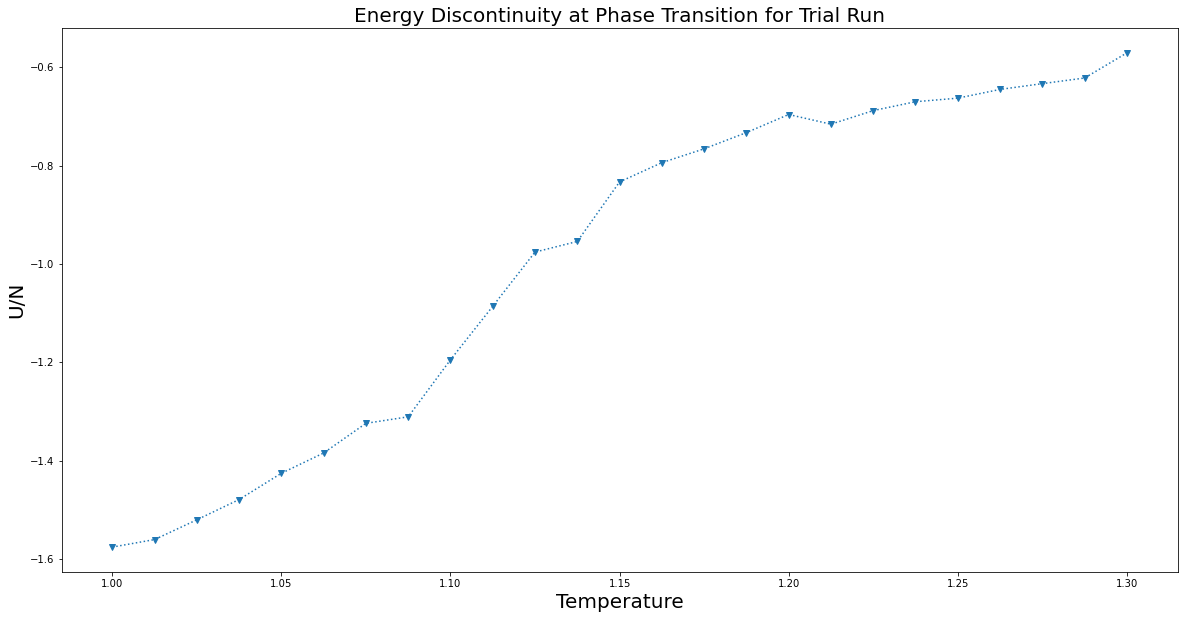

In [104]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(temp_list, ene_avg_list, linestyle = 'dotted', marker = 'v')
ax.set_title('Energy Discontinuity at Phase Transition for Trial Run', fontsize = 20)
ax.set_xlabel("Temperature", fontsize = 20)
ax.set_ylabel("U/N", fontsize = 20)

We now want to track the cluster size in our runs. Doing so is easy, as our cluster function returns the array C of all cluster values, so we just take len(C)

In [117]:
cluster_len_list = []
energy_list = []
lattice_testx, lattice_testy, lattice_testz = initialize2(10, "uniform", 17)
for i in range(1000):
    print(i/1000)
    cluster_len_list.append(len(cluster(lattice_testx, lattice_testy, lattice_testz, rng, 2)))
    ene_sum = 0
    for q in range(10):
        for y in range(10):
            for z in range(10):
                ene_sum += ene_tot2(lattice_testx,lattice_testy,lattice_testz,(q,y,z))
    energy_list.append(ene_sum)
    
    

0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009
0.01
0.011
0.012
0.013
0.014
0.015
0.016
0.017
0.018
0.019
0.02
0.021
0.022
0.023
0.024
0.025
0.026
0.027
0.028
0.029
0.03
0.031
0.032
0.033
0.034
0.035
0.036
0.037
0.038
0.039
0.04
0.041
0.042
0.043
0.044
0.045
0.046
0.047
0.048
0.049
0.05
0.051
0.052
0.053
0.054
0.055
0.056
0.057
0.058
0.059
0.06
0.061
0.062
0.063
0.064
0.065
0.066
0.067
0.068
0.069
0.07
0.071
0.072
0.073
0.074
0.075
0.076
0.077
0.078
0.079
0.08
0.081
0.082
0.083
0.084
0.085
0.086
0.087
0.088
0.089
0.09
0.091
0.092
0.093
0.094
0.095
0.096
0.097
0.098
0.099
0.1
0.101
0.102
0.103
0.104
0.105
0.106
0.107
0.108
0.109
0.11
0.111
0.112
0.113
0.114
0.115
0.116
0.117
0.118
0.119
0.12
0.121
0.122
0.123
0.124
0.125
0.126
0.127
0.128
0.129
0.13
0.131
0.132
0.133
0.134
0.135
0.136
0.137
0.138
0.139
0.14
0.141
0.142
0.143
0.144
0.145
0.146
0.147
0.148
0.149
0.15
0.151
0.152
0.153
0.154
0.155
0.156
0.157
0.158
0.159
0.16
0.161
0.162
0.163
0.164
0.165
0.166
0.167
0.168
0.169

Text(0.5, 1.0, 'Progression of Cluster Size from Uniform Initialization, T = 2')

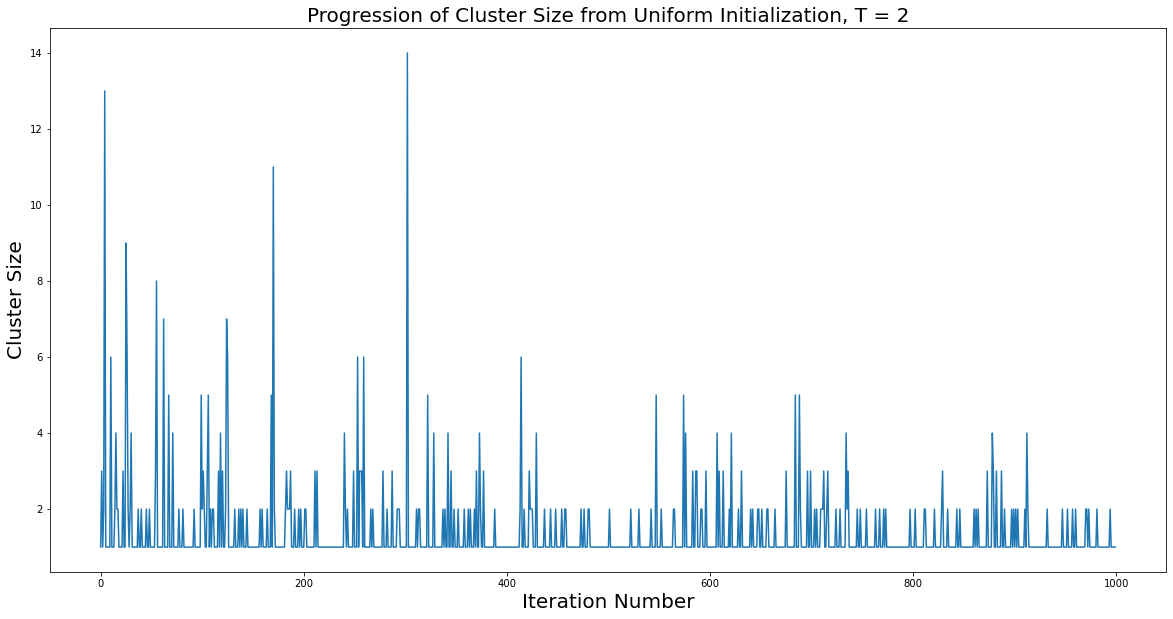

In [136]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(cluster_len_list)
ax.set_xlabel("Iteration Number", fontsize = 20)
ax.set_ylabel("Cluster Size", fontsize = 20)
ax.set_title("Progression of Cluster Size from Uniform Initialization, T = 2", fontsize = 20)

In [123]:
cluster_len_list1 = []
energy_list1 = []
lattice_testx, lattice_testy, lattice_testz = initialize2(10, "uniform", 17)
for i in range(1000):
    print(i/1000)
    cluster_len_list1.append(len(cluster(lattice_testx, lattice_testy, lattice_testz, rng, 1)))
    ene_sum = 0
    for q in range(10):
        for y in range(10):
            for z in range(10):
                ene_sum += ene_tot2(lattice_testx,lattice_testy,lattice_testz,(q,y,z))
    energy_list1.append(ene_sum)
    
    

0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009
0.01
0.011
0.012
0.013
0.014
0.015
0.016
0.017
0.018
0.019
0.02
0.021
0.022
0.023
0.024
0.025
0.026
0.027
0.028
0.029
0.03
0.031
0.032
0.033
0.034
0.035
0.036
0.037
0.038
0.039
0.04
0.041
0.042
0.043
0.044
0.045
0.046
0.047
0.048
0.049
0.05
0.051
0.052
0.053
0.054
0.055
0.056
0.057
0.058
0.059
0.06
0.061
0.062
0.063
0.064
0.065
0.066
0.067
0.068
0.069
0.07
0.071
0.072
0.073
0.074
0.075
0.076
0.077
0.078
0.079
0.08
0.081
0.082
0.083
0.084
0.085
0.086
0.087
0.088
0.089
0.09
0.091
0.092
0.093
0.094
0.095
0.096
0.097
0.098
0.099
0.1
0.101
0.102
0.103
0.104
0.105
0.106
0.107
0.108
0.109
0.11
0.111
0.112
0.113
0.114
0.115
0.116
0.117
0.118
0.119
0.12
0.121
0.122
0.123
0.124
0.125
0.126
0.127
0.128
0.129
0.13
0.131
0.132
0.133
0.134
0.135
0.136
0.137
0.138
0.139
0.14
0.141
0.142
0.143
0.144
0.145
0.146
0.147
0.148
0.149
0.15
0.151
0.152
0.153
0.154
0.155
0.156
0.157
0.158
0.159
0.16
0.161
0.162
0.163
0.164
0.165
0.166
0.167
0.168
0.169

Text(0.5, 1.0, 'Progression of Cluster Size from Uniform Initialization, T = 1')

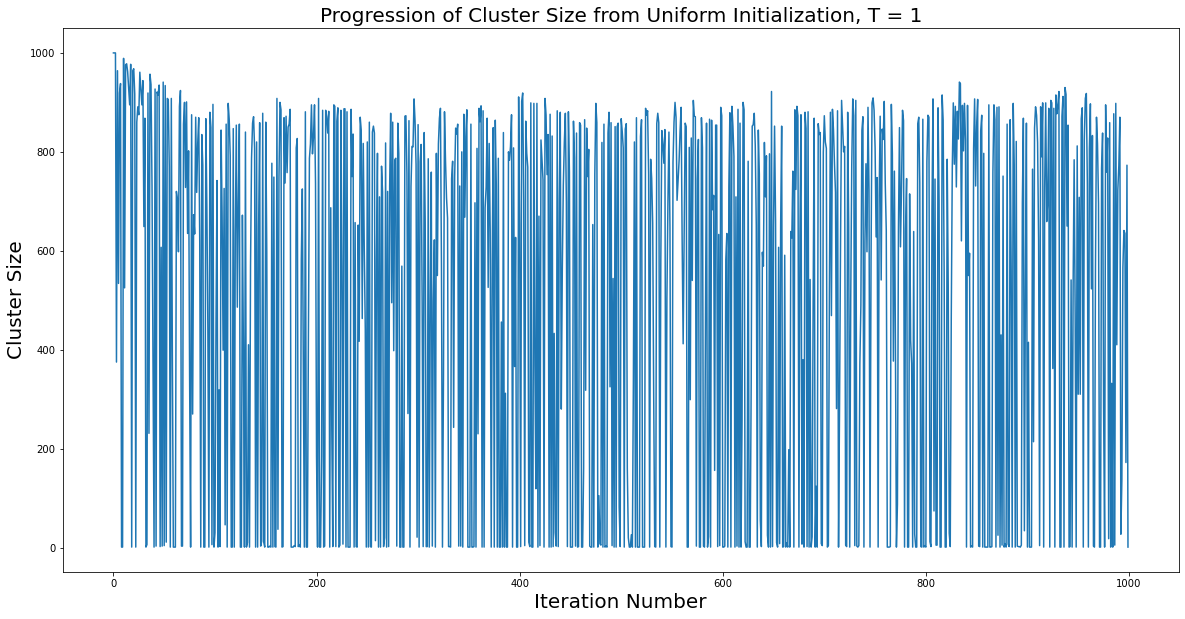

In [124]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(cluster_len_list1)
ax.set_xlabel("Iteration Number", fontsize = 20)
ax.set_ylabel("Cluster Size", fontsize = 20)
ax.set_title("Progression of Cluster Size from Uniform Initialization, T = 1", fontsize = 20)

In [125]:
Temp_list = np.linspace(0.1, 10, 20)

In [127]:
avg_clust = []
for T in Temp_list:
    print(T)
    cluster_len_list = []
    lattice_testx, lattice_testy, lattice_testz = initialize2(10, "uniform", 17)
    for i in range(1000):
        cluster_len_list.append(len(cluster(lattice_testx, lattice_testy, lattice_testz, rng, T)))
    avg = np.mean(cluster_len_list[500:1000])
    avg_clust.append(avg)

0.1
0.6210526315789474
1.142105263157895
1.6631578947368424
2.18421052631579
2.7052631578947373
3.2263157894736847
3.747368421052632
4.268421052631579
4.7894736842105265
5.310526315789474
5.831578947368421
6.352631578947369
6.873684210526316
7.394736842105264
7.915789473684211
8.436842105263159
8.957894736842105
9.478947368421053
10.0


Text(0.5, 0, 'Temperature')

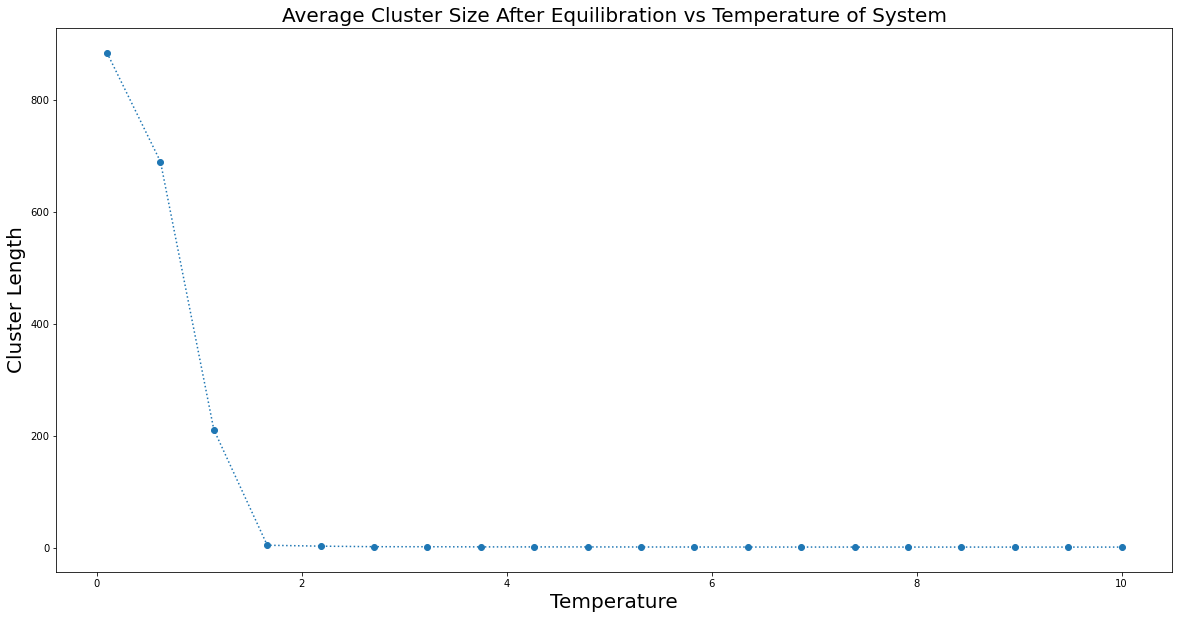

In [133]:
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(Temp_list, avg_clust, linestyle = 'dotted', marker = 'o')
ax.set_title("Average Cluster Size After Equilibration vs Temperature of System", fontsize = 20)
ax.set_ylabel("Cluster Length", fontsize = 20)
ax.set_xlabel("Temperature", fontsize = 20)